<a href="https://colab.research.google.com/github/luisjti/Ai/blob/main/Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from random import randint

class HalvingGame:
    def __init__(self, N_start=None, max_N=20):
        if not N_start: N_start = randint(1, max_N)
        self.N_start = N_start

    def startState(self):
        player = +1
        return (player, self.N_start)

    def isEnd(self, state):
        p, N = state
        return N == 0

    def utility(self, state):
        p, N = state
        assert N == 0
        return p*float('inf')

    def actions(self, state):
        return ['-', '/']

    def player(self, state):
        p, N = state
        return p

    def successor(self, state, action):
        p, N = state
        if action == '-':
            return (-p, N - 1)
        if action == '/':
            return (-p, N//2)

def humanPolicy(game, state):
    while True:
        action = input(f'P({state[0]}) [- or /]: ')
        if action in game.actions(state):
            return action

def run_game(policies, N_start=None, max_N=20):
    game = HalvingGame(N_start, max_N)
    state = game.startState()
    while not game.isEnd(state):
        print('='*10, state)
        player = game.player(state)
        policy = policies[player]
        action = policy(game, state)
        state = game.successor(state, action)


    print(f'utility = {game.utility(state)}')

In [ ]:
def minimaxPolicy(game, state):
    def minimaxValue(state, player):
        if game.isEnd(state):
            return game.utility(state)

        actions = game.actions(state)
        if player == 1:
            current_utility = float('-inf')
            for action in actions:
                next_state = game.successor(state, action)
                utility = minimaxValue(next_state, -1)
                current_utility = max(current_utility, utility)
        else:
            current_utility = float('inf')
            for action in actions:
                next_state = game.successor(state, action)
                utility = minimaxValue(next_state, 1)
                current_utility = min(current_utility, utility)
        utility = current_utility
        return utility

    player = game.player(state)
    actions = game.actions(state)

    if state == (1,1) or state == (-1,1):
        return '-'

    current_action = None
    current_utility = float('-inf') if player == 1 else float('inf')

    for action in actions:
        next_state = game.successor(state, action)
        utility = minimaxValue(next_state, player)

        if (player == 1 and utility > current_utility) or (player == -1 and utility < current_utility):
            current_utility = utility
            current_action = action
    action = current_action
    return action



========== (1, 1)
utility = -inf
========== (1, 2)
========== (-1, 1)
utility = inf
========== (1, 3)
========== (-1, 1)
utility = inf
========== (1, 4)
========== (-1, 3)
========== (1, 1)
utility = -inf
========== (1, 5)
========== (-1, 4)
========== (1, 3)
========== (-1, 1)
utility = inf
========== (1, 6)
========== (-1, 5)
========== (1, 4)
========== (-1, 3)
========== (1, 1)
utility = -inf
========== (1, 7)
========== (-1, 3)
========== (1, 1)
utility = -inf
========== (1, 8)
========== (-1, 7)
========== (1, 3)
========== (-1, 1)
utility = inf
========== (1, 9)
========== (-1, 4)
========== (1, 3)
========== (-1, 1)
utility = inf
========== (1, 10)
========== (-1, 9)
========== (1, 4)
========== (-1, 3)
========== (1, 1)
utility = -inf
========== (1, 11)
========== (-1, 5)
========== (1, 4)
========== (-1, 3)
========== (1, 1)
utility = -inf
========== (1, 12)
========== (-1, 11)
========== (1, 5)
========== (-1, 4)
========== (1, 3)
========== (-1, 1)
utility = inf
========== 

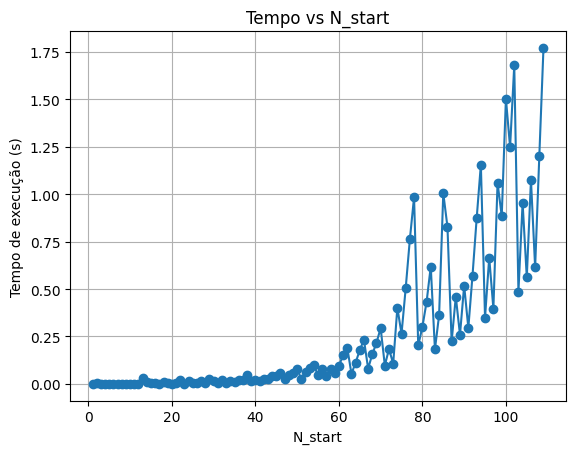

In [ ]:
import time
import matplotlib.pyplot as plt

policies = {+1: minimaxPolicy, -1: minimaxPolicy}
execution_times = []

for N_start in range(1, 1000):
    start_time = time.time()
    run_game(policies, N_start, max_N=1000)
    end_time = time.time()
    elapsed_time = end_time - start_time
    if elapsed_time > 3:
      break
    execution_times.append(elapsed_time)

plt.plot(range(1, len(execution_times) + 1), execution_times, marker='o')
plt.xlabel("N_start")
plt.ylabel("Tempo de execução (s)")
plt.title("Tempo vs N_start")
plt.grid(True)
plt.show()



In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 10.4 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

In [ ]:
from collections import defaultdict
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt


class FrozenLakeAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,

    ):
        """Inicializa um agente de RL com um dict vazio de q_values,
        uma taxa de aprendizado e um epsilon.

        Args:
            learning_rate: taxa de aprendizado
            initial_epsilon: valor inicial de epsilon
            epsilon_decay: fator de decaimento de epsilon
            final_epsilon: valor final de epsilon
            discount_factor: fator de disconto para calcular os q_values
        """
        self.num_actions = env.action_space.n
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

    def get_action(self, state):
      explore_chance = random.random()

      if explore_chance < self.epsilon:
          return random.randint(0, 3)
      else:
          max_q_value = max(self.q_values[state])
          best_actions = [action for action, q_value in enumerate(self.q_values[state]) if q_value == max_q_value]
          chosen_action = random.choice(best_actions)
          return chosen_action


    def update(
        self,
        state,
        action,
        reward,
        done,
        next_state,
    ):
      learning_rate = self.lr
      discount_factor = self.discount_factor
      current_q_value = self.q_values[state][action]
      max_q_value_next_state = max(self.q_values[next_state])
      new_q_value = (1 - learning_rate) * current_q_value + learning_rate * (reward + discount_factor * max_q_value_next_state)
      self.q_values[state][action] = new_q_value

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [ ]:
# hyperparameters
learning_rate =  0.20
n_episodes = 1000
start_epsilon = 0.990
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.010
discount_factor = 1

agent = FrozenLakeAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor = discount_factor,
)

## Fluxo de Interação

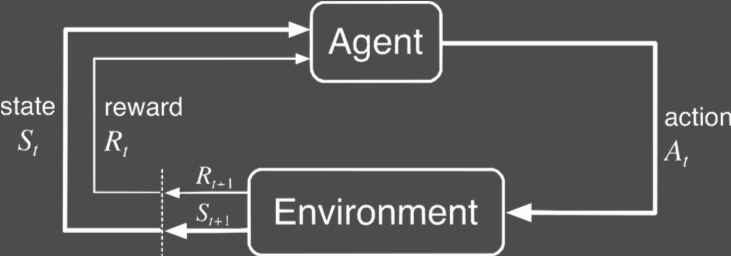

In [ ]:
from tqdm import tqdm

def evaluate_agent():
  original_epsilon = agent.epsilon
  agent.epsilon = 0
  episodes = 200
  totalReward = 0
  for i in range(episodes):
    state, info = env.reset()
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
    totalReward += reward
  agent.epsilon = original_epsilon
  average_reward = totalReward/episodes
  return average_reward

episode_rewards = []
for episode in tqdm(range(int(n_episodes))):
    state, info = env.reset()
    done = False
    total_reward = 0

    # play one episode
    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        # update the agent
        done = terminated or truncated
        agent.update(state, action, reward, done, next_state)

        # update the current state
        state = next_state
        total_reward += reward

    agent.decay_epsilon()
    value = evaluate_agent()
    episode_rewards.append(value)
env.close()

100%|██████████| 1000/1000 [02:47<00:00,  5.96it/s]


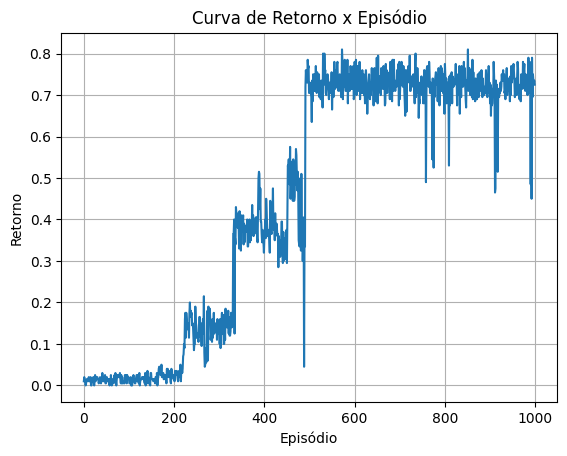

In [ ]:
plt.plot(episode_rewards)
plt.xlabel('Episódio')
plt.ylabel('Retorno')
plt.title('Curva de Retorno x Episódio')
plt.grid(True)
plt.show()
